## Sign Language Recognition (A-Z)
* CNN Model
* ASL Dataset 
    * 26 classes(A-Z) + 3 classes(del, nothing, space)
    * 3000 images for each class
    * data structure:
        * data
            * asl_alphabet_train
                * A
                    * 3000 images
                * B
                    * 3000 images
                  ...
* Onnx Deployed Model Url : https://monikapnw.github.io/ML_Deployment_ASL/



## Importing Libraries

In [9]:
import torch
import torchvision
from torchvision import transforms, datasets
import matplotlib.pyplot as plt

import pandas 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import torchvision
from torchvision import datasets
from torchvision import transforms

import torch
from torch.utils.data import Dataset
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F

from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score

import os
import onnxruntime as rt
import onnxmltools

from skl2onnx.common.data_types import FloatTensorType

from tqdm import tqdm
from time import time

## Data

In [10]:
test_size = 0.2
batch_size = 32
num_epoch = 10
learning_rate = 0.001
num_classes = 29

In [11]:
train_data_path = "data/asl_alphabet_train/"
train_transforms = transforms.Compose([
    transforms.Resize(224),
    transforms.ToTensor()
])
test_transforms = transforms.Compose([
    transforms.Resize(224), 
    transforms.ToTensor()
])

In [12]:
%%time
dataset = datasets.ImageFolder(train_data_path, transform=train_transforms)
num_train_samples = len(dataset)
dataset

Wall time: 15.8 s


Dataset ImageFolder
    Number of datapoints: 87000
    Root location: data/asl_alphabet_train/
    StandardTransform
Transform: Compose(
               Resize(size=224, interpolation=bilinear, max_size=None, antialias=None)
               ToTensor()
           )

In [13]:
torch.manual_seed(1)
indices = torch.randperm(num_train_samples)

split = int(num_train_samples * test_size)

train_dataset = torch.utils.data.Subset(dataset, indices[split:])
test_dataset = torch.utils.data.Subset(dataset, indices[:split])

len(train_dataset), len(test_dataset)

(69600, 17400)

In [14]:
train_dataloader = torch.utils.data.DataLoader(dataset=train_dataset,
                                               batch_size=batch_size, 
                                               shuffle=True, 
                                               num_workers=4)

test_dataloader = torch.utils.data.DataLoader(dataset=test_dataset,
                                              batch_size=batch_size,
                                              shuffle=False,
                                              num_workers=4)

In [15]:
classes = train_dataloader.dataset.dataset.classes
print(classes)

['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'del', 'nothing', 'space']


Ground truth Y


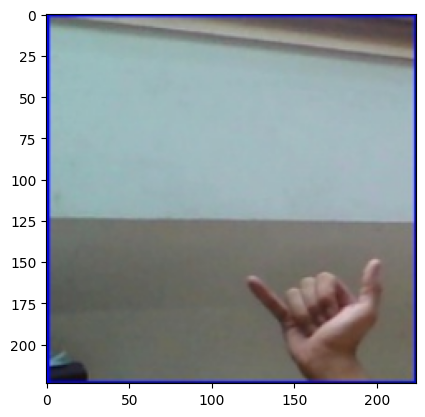

In [16]:
for img, label in train_dataloader:
    print('Ground truth', classes[label[0]])
    plt.imshow(img[0].permute(1, 2, 0))
    plt.show()
    break

## Model

In [17]:
model = nn.Sequential(
            nn.Conv2d(3, 8, 5),  #[N, 8, 224-5+1, 224-5+1] = [N, 8, 220, 220]
            nn.BatchNorm2d(8),
            nn.MaxPool2d(2,2), #[N, 8, 220/2, 220/2] = [N, 8, 110, 110]
            nn.ReLU(),                      
                             

            nn.Conv2d(8, 16,5),#[N,16,110-5+1,110-5+1]  = [N, 16, 106, 106]
            nn.BatchNorm2d(16),
            nn.MaxPool2d(2,2),  #[N,16,106/2,106/2] = [N, 16, 53, 53]
            nn.ReLU(),
    
            nn.Conv2d(16, 32,5),#[N,32,53-5+1,53-5+1]  = [N, 32, 49, 49]
            nn.BatchNorm2d(32),
            nn.MaxPool2d(2,2),  #[N,32, 49/2,49/2] = [N, 32, 24, 24]
            nn.ReLU(),
    
            nn.Conv2d(32, 64,5),#[N,64,24-5+1,24-5+1]  = [N, 64, 20, 20]
            nn.BatchNorm2d(64),
            nn.MaxPool2d(2,2),  #[N,64, 20/2,20/2] = [N, 64, 10, 10]
            nn.ReLU(),
    
            nn.Conv2d(64, 128,5),#[N,128,10-5+1,10-5+1]  = [N, 128, 6, 6]
            nn.BatchNorm2d(128),
            nn.MaxPool2d(2,2),  #[N,128, 6/2,6/2] = [N, 128, 3, 3]
            nn.ReLU(),
    
            nn.Flatten(),
            
            nn.Linear(1152, 100), #128*3*3= 1152
            nn.LeakyReLU(),
            nn.Dropout(0.3),
            nn.Linear(100, 29),
            nn.Sigmoid()

        )

## Training

In [18]:
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [19]:
print_every = 1000
steps = 0
train_losses, val_losses = [], []

for epoch in tqdm(range(num_epoch)):
    iterations = 0
    running_loss = 0
    correct_train = 0
    total_train = 0
    start_time = time()
    
    model.train()
    for i, (images, labels) in enumerate(train_dataloader):
        steps += 1
        
        output = model(images)
        loss = criterion(output, labels)
    
        correct_train += (torch.max(output, dim=1)[1] == labels).sum()
        total_train += labels.size(0)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        iterations += 1
        running_loss += loss.item()
        
        if steps % print_every == 0:
            print(f'Epoch [{epoch + 1}]/[{num_epoch}]. Batch [{i + 1}]/[{len(train_dataloader)}]. Train loss {running_loss / steps}.', end=' ')
            print(f'Train acc {correct_train / total_train * 100}.', end=' ')
            

  0%|                                                                                           | 0/10 [00:00<?, ?it/s]

Epoch [1]/[10]. Batch [1000]/[2175]. Train loss 2.7705249485969543. Train acc 42.75312423706055. Epoch [1]/[10]. Batch [2000]/[2175]. Train loss 2.657778249502182. Train acc 57.381248474121094. 

 10%|███████▉                                                                       | 1/10 [36:45<5:30:49, 2205.46s/it]

Epoch [2]/[10]. Batch [825]/[2175]. Train loss 0.6874473639329275. Train acc 79.28787994384766. Epoch [2]/[10]. Batch [1825]/[2175]. Train loss 1.136525101840496. Train acc 81.02054595947266. 

 20%|███████████████▍                                                             | 2/10 [1:04:06<4:09:46, 1873.29s/it]

Epoch [3]/[10]. Batch [650]/[2175]. Train loss 0.32118531880378726. Train acc 86.1730728149414. Epoch [3]/[10]. Batch [1650]/[2175]. Train loss 0.6783069777091344. Train acc 86.75. 

 30%|███████████████████████                                                      | 3/10 [1:34:17<3:35:14, 1844.89s/it]

Epoch [4]/[10]. Batch [475]/[2175]. Train loss 0.16680661688532147. Train acc 88.28947448730469. Epoch [4]/[10]. Batch [1475]/[2175]. Train loss 0.4531247847378254. Train acc 88.80508422851562. 

 40%|██████████████████████████████▊                                              | 4/10 [2:08:00<3:11:32, 1915.46s/it]

Epoch [5]/[10]. Batch [300]/[2175]. Train loss 0.08189485920800103. Train acc 89.65625. Epoch [5]/[10]. Batch [1300]/[2175]. Train loss 0.3189889865636826. Train acc 90.3605728149414. 

 50%|██████████████████████████████████████▌                                      | 5/10 [3:05:56<3:26:30, 2478.03s/it]

Epoch [6]/[10]. Batch [125]/[2175]. Train loss 0.027817045970396564. Train acc 91.375. Epoch [6]/[10]. Batch [1125]/[2175]. Train loss 0.22952988024552662. Train acc 92.07500457763672. Epoch [6]/[10]. Batch [2125]/[2175]. Train loss 0.40015823267056394. Train acc 92.3691177368164. 

 60%|██████████████████████████████████████████████▏                              | 6/10 [4:04:57<3:09:17, 2839.28s/it]

Epoch [7]/[10]. Batch [950]/[2175]. Train loss 0.16595297832148415. Train acc 93.22368621826172. Epoch [7]/[10]. Batch [1950]/[2175]. Train loss 0.31772813951174417. Train acc 93.7996826171875. 

 70%|█████████████████████████████████████████████████████▉                       | 7/10 [5:01:11<2:30:43, 3014.40s/it]

Epoch [8]/[10]. Batch [775]/[2175]. Train loss 0.11837544094026088. Train acc 93.61289978027344. Epoch [8]/[10]. Batch [1775]/[2175]. Train loss 0.25514538924834307. Train acc 93.79049682617188. 

 80%|█████████████████████████████████████████████████████████████▌               | 8/10 [5:28:55<1:26:08, 2584.32s/it]

Epoch [9]/[10]. Batch [600]/[2175]. Train loss 0.08137500695387523. Train acc 94.59896087646484. Epoch [9]/[10]. Batch [1600]/[2175]. Train loss 0.20554711095910325. Train acc 95.11328125. 

 90%|███████████████████████████████████████████████████████████████████████        | 9/10 [5:57:12<38:26, 2306.89s/it]

Epoch [10]/[10]. Batch [425]/[2175]. Train loss 0.05183809899091721. Train acc 95.5367660522461. Epoch [10]/[10]. Batch [1425]/[2175]. Train loss 0.1655966524056026. Train acc 95.43859100341797. 

100%|██████████████████████████████████████████████████████████████████████████████| 10/10 [6:29:13<00:00, 2335.36s/it]


## Test

In [20]:
def print_metrics_function(y_test, y_pred):
    print('Accuracy: %.2f' % accuracy_score(y_test, y_pred))
    confmat = confusion_matrix(y_true=y_test, y_pred=y_pred)
    print("Confusion Matrix:")
    print(confmat)
    print('Precision: %.3f' % precision_score(y_true=y_test, y_pred=y_pred, average='weighted'))
    print('Recall: %.3f' % recall_score(y_true=y_test, y_pred=y_pred, average='weighted'))
    print('F1-measure: %.3f' % f1_score(y_true=y_test, y_pred=y_pred, average='weighted'))

In [21]:
with torch.no_grad():
    model.eval()
    correct_val, total_val = 0, 0
    val_loss = 0
    labels_list = []
    preds_list = []
    for images, labels in test_dataloader:
        output = model(images)
        loss = criterion(output, labels)
        val_loss += loss.item()

        correct_val += (torch.max(output, dim=1)[1] == labels).sum()
        total_val += labels.size(0)

        print(f'Test loss {val_loss / len(test_dataloader)}. Test acc {correct_val / total_val * 100}')

        train_losses.append(running_loss / total_train)
        val_losses.append(val_loss / total_val)
        
        labels_list.append(labels)
        preds_list.append(torch.max(output, dim=1)[1])
        
        
    print(f'Epoch took {time() - start_time}') 
    torch.save(model, f'checkpoint_{correct_val / total_val * 100:.2f}')


Test loss 0.0044688976862851315. Test acc 100.0
Test loss 0.008939191260758568. Test acc 100.0
Test loss 0.013412386617239784. Test acc 98.95832824707031
Test loss 0.017880773281349856. Test acc 98.4375
Test loss 0.022344548912609324. Test acc 98.75
Test loss 0.02682456417995341. Test acc 98.4375
Test loss 0.03129615809987573. Test acc 98.21428680419922
Test loss 0.035769335049040174. Test acc 97.65625
Test loss 0.04023836158654269. Test acc 97.91667175292969
Test loss 0.044710659805466145. Test acc 97.5
Test loss 0.04917749762535095. Test acc 97.7272720336914
Test loss 0.05365260427489. Test acc 97.91667175292969
Test loss 0.05811938994071063. Test acc 98.07691955566406
Test loss 0.06259281275903478. Test acc 97.76786041259766
Test loss 0.06706133309532614. Test acc 97.70833587646484
Test loss 0.07153175552101697. Test acc 97.8515625
Test loss 0.07600107438424054. Test acc 97.97794342041016
Test loss 0.08047319335096023. Test acc 98.09027862548828
Test loss 0.08494842797517776. Test a

Test loss 0.6573526539346751. Test acc 97.64030456542969
Test loss 0.6618165106457823. Test acc 97.65625
Test loss 0.6662825845620212. Test acc 97.67198181152344
Test loss 0.670751649667235. Test acc 97.66667175292969
Test loss 0.6752155247856589. Test acc 97.68212127685547
Test loss 0.6796859927913722. Test acc 97.69737243652344
Test loss 0.6841484430958243. Test acc 97.71241760253906
Test loss 0.6886091683717335. Test acc 97.7272720336914
Test loss 0.6930786055677077. Test acc 97.70161437988281
Test loss 0.6975435084279846. Test acc 97.71634674072266
Test loss 0.7020245921962401. Test acc 97.69108581542969
Test loss 0.7064889253062361. Test acc 97.6859130859375
Test loss 0.7109598898712326. Test acc 97.64151000976562
Test loss 0.7154347721268149. Test acc 97.6171875
Test loss 0.7198970756110024. Test acc 97.63198852539062
Test loss 0.7243577386526501. Test acc 97.62731170654297
Test loss 0.728828556397382. Test acc 97.64187622070312
Test loss 0.7332953376805081. Test acc 97.637191772

Test loss 1.3145710935487467. Test acc 97.72533416748047
Test loss 1.3190453578444088. Test acc 97.72245788574219
Test loss 1.3235310706145622. Test acc 97.70903778076172
Test loss 1.3280041923417765. Test acc 97.71675109863281
Test loss 1.3324734371374636. Test acc 97.70343780517578
Test loss 1.3369467135737925. Test acc 97.71112060546875
Test loss 1.3414134729434462. Test acc 97.71875
Test loss 1.3458790340844322. Test acc 97.7159423828125
Test loss 1.3503543480354196. Test acc 97.7235107421875
Test loss 1.3548293736051111. Test acc 97.73102569580078
Test loss 1.3593202198252958. Test acc 97.72820281982422
Test loss 1.3637976484263645. Test acc 97.73565673828125
Test loss 1.3682596359182806. Test acc 97.74305725097656
Test loss 1.3727269830072628. Test acc 97.75040435791016
Test loss 1.3771967922939974. Test acc 97.74756622314453
Test loss 1.3816776674459963. Test acc 97.75485229492188
Test loss 1.3861453248297466. Test acc 97.76209259033203
Test loss 1.390611568794531. Test acc 97.7

Test loss 1.9675778781666475. Test acc 97.79119873046875
Test loss 1.9720963813802774. Test acc 97.78911590576172
Test loss 1.976557104903109. Test acc 97.79411315917969
Test loss 1.9810353990863352. Test acc 97.78498840332031
Test loss 1.9855110180728577. Test acc 97.78997802734375
Test loss 1.9899801090359688. Test acc 97.78792572021484
Test loss 1.9944566146415823. Test acc 97.78587341308594
Test loss 1.9989203411866636. Test acc 97.7838363647461
Test loss 2.003391632262398. Test acc 97.78878021240234
Test loss 2.0078684095950687. Test acc 97.78675079345703
Test loss 2.012358328437104. Test acc 97.78472137451172
Test loss 2.0168310745674023. Test acc 97.78270721435547
Test loss 2.021302448476062. Test acc 97.78070068359375
Test loss 2.025766020312029. Test acc 97.78559875488281
Test loss 2.030234137440429. Test acc 97.79047393798828
Test loss 2.0346960486734615. Test acc 97.78845977783203
Test loss 2.039155520937022. Test acc 97.7933120727539
Test loss 2.043616265496787. Test acc 97

In [22]:
labels_np = np.concatenate(labels_list)
preds_np = np.concatenate(preds_list)
print_metrics_function(labels_np, preds_np)

Accuracy: 0.98
Confusion Matrix:
[[563   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0]
 [  0 625   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   1   0   0   0   0   0   0]
 [  0   0 611   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   4   0   0   0]
 [  0   0   0 569   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0 591   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0 574   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0 574   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0 600   0   0   0   0   0   0   0   3   0   0
    0   0   0   0   0   0   0   0   4   0   0]

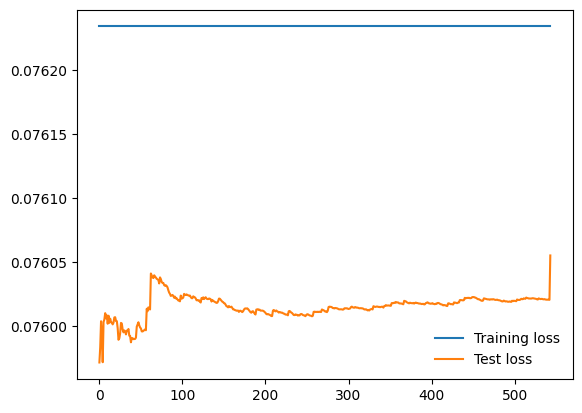

In [23]:
plt.plot(train_losses, label='Training loss')
plt.plot(val_losses, label='Test loss')
plt.legend(frameon=False)
plt.show()

## Saving Model

In [24]:
model.eval()

dummy_input = torch.randn(1, 3, 224, 224)
input_names = ["input1"]
output_names = ["output1"]

torch.onnx.export(
    model,
    dummy_input,
    "model/asl_sign.onnx",
    verbose = False, 
    input_names = input_names,
    output_names = output_names
)

## Test On Images

In [25]:
from pathlib import Path
from PIL import Image


test_data_path = Path('data/asl_alphabet_test/')


class ASLTestDataset(torch.utils.data.Dataset):
    def __init__(self, root_path, transforms=None):
        super().__init__()
        
        self.transforms = transforms
        self.imgs = sorted(list(Path(root_path).glob('*.jpg')))
        
    def __len__(self):
        return len(self.imgs)
    
    def __getitem__(self, idx):
        img_path = self.imgs[idx]
        img = Image.open(img_path).convert('RGB')
        
        label = img_path.parts[-1].split('_')[0]
        if self.transforms:
            img = self.transforms(img)
        
        return img, label

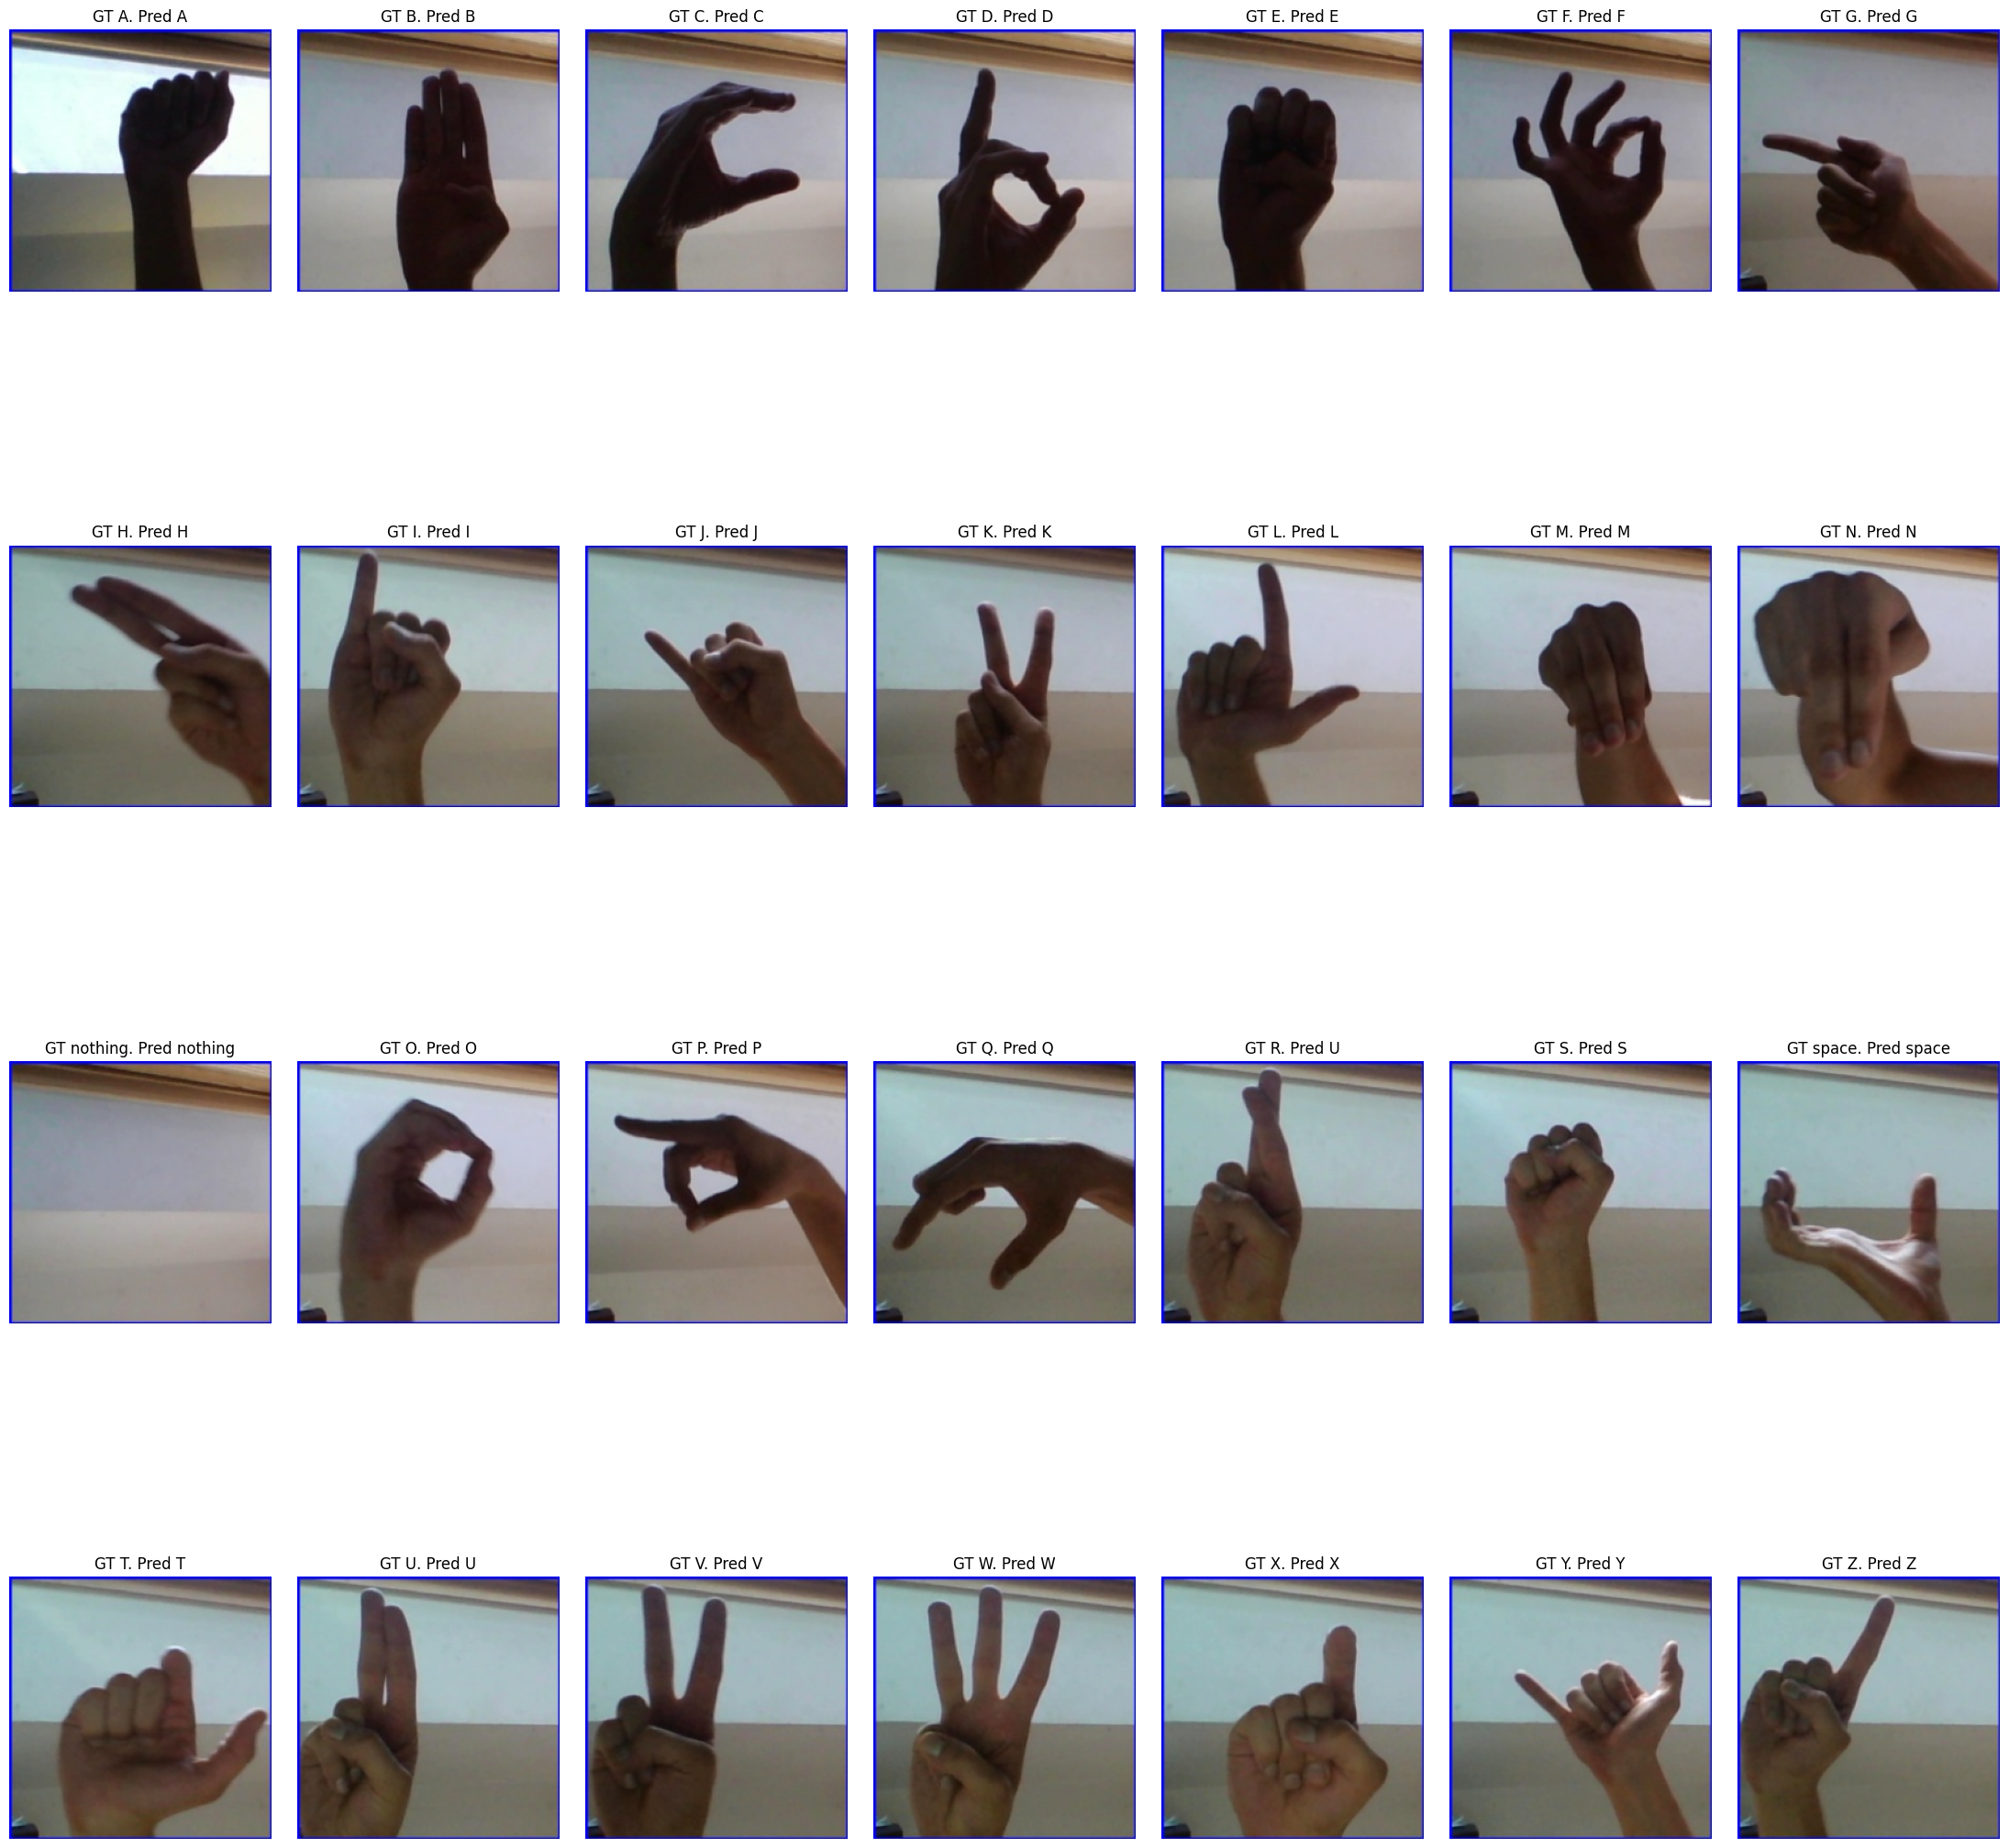

In [26]:
test_dataset = ASLTestDataset(test_data_path, transforms=test_transforms)

columns = 7
row = round(len(test_dataset) / columns)

fig, ax = plt.subplots(row, columns, figsize=(columns * row, row * columns))
plt.subplots_adjust(wspace=0.1, hspace=0.2)

i, j = 0, 0
for img, label in test_dataset:
    img = torch.Tensor(img)
    #img = img.to(device)
    model.eval()
    prediction = model(img[None])

    ax[i][j].imshow(img.permute(1, 2, 0))
    ax[i][j].set_title(f'GT {label}. Pred {classes[torch.max(prediction, dim=1)[1]]}')
    ax[i][j].axis('off')
    j += 1
    if j == columns:
        j = 0
        i += 1
        
plt.show()

## Test on Webcam

In [27]:
sess = rt.InferenceSession("model/asl_sign.onnx")
input_name = sess.get_inputs()[0].name
label_name = sess.get_outputs()[0].name

In [28]:
print(input_name, label_name)

input1 output1


In [29]:
def getLetter(result):
    classLabels = {
        0:'A',
        1:'B',
        2:'C',
        3:'D',
        4:'E',
        5:'F',
        6:'G',
        7:'H',
        8:'I',
        9:'J',
        10:'K',
        11:'L',
        12:'M',
        13:'N',
        14:'O',
        15:'P',
        16:'Q',
        17:'R',
        18:'S',
        19:'T',
        20:'U',
        21:'V',
        22:'W',
        23:'X',
        24:'Y',
        25:'Z',
        26:'del',
        27:'nothing',
        28:'space'
    }
    try:
        res=int(result)
        return classLabels[res]
    except:
        return "Error"

In [30]:
import cv2

cap = cv2.VideoCapture(0)
while cap.isOpened():
    ret, frame = cap.read()

    frame = cv2.resize(frame, (224, 224))
    
    #show image
    cv2.imshow("Webcam", frame)

    # Convert the resized image to a PyTorch tensor and permute for channel first
    resized_tensor = torch.tensor(frame, dtype=torch.float32).unsqueeze(0) / 255.0
    permuted_tensor = resized_tensor.permute(0, 3, 1, 2)

    # Print the sizes of the original and resized tensors
    #print("Original size:", frame.shape)
    #print("Resized size:", resized_tensor.size())
    #print("Permuted size: ",permuted_tensor.size())
    

    output = sess.run([sess.get_outputs()[0].name], {input_name : permuted_tensor.numpy()})
    pred = np.argmax(np.array(output))
    result = getLetter(pred.item())
    cv2.putText(frame, result, (100, 200), cv2.FONT_HERSHEY_COMPLEX, 2, (0, 255, 0), 2)
    cv2.imshow("Prediction", frame)

    
    if(cv2.waitKey(1) & 0xFF == ord('q')):
        break

cap.release()
cv2.destroyAllWindows()
